# Time-Optimal Control Exercise

In [1]:
import os
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import MX, DM, Function, Opti
import casadi as cas
from platform import python_version

print(f"Casadi: {cas.__version__}")
print(f"Python: {python_version()}")

Casadi: 3.6.5
Python: 3.10.13


In [2]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## 1. The Effect of Non-fixed Time on Problem Structure.

In [3]:
# Physical constants

T = 1.0  # control horizon [s]
N = 20  # Number of control intervals

tgrid = np.linspace(0, T, N+1)

### Define continuous-time system

$\dot{x} = f(x,u)$

In [4]:
nx = 4

# Construct function for the ODE right-hand side
x = MX.sym('x', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
u = MX.sym('u', 2)  # control force [N]
rhs = cas.vertcat(x[2:4], u)

# Continuous system dynamics as a CasADi Function
f = Function('f', [x, u], [rhs])
f

Function(f:(i0[4],i1[2])->(o0[4]) MXFunction)

### Define discrete-time system

$x_{k+1} = F(x_k, u_k)$

In [5]:
# Construct function for the ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]

# Step size
dt = T / N  # length of 1 control interval [s]

# RK4 approximation
f1 = f(xk, uk)
f2 = f(xk + dt/2 * f1, uk)
f3 = f(xk + dt/2 * f2, uk)
f4 = f(xk + dt * f3, uk)
xkp1 = xk + dt / 6 * (f1 + 2 * f2 + 2 * f3 + f4)

F = Function('F', [xk, uk], [xkp1], ['xk', 'uk'], ['xkp1'])
F

Function(F:(xk[4],uk[2])->(xkp1[4]) MXFunction)

### Waypoints

In [6]:
ref = cas.horzcat(cas.sin(np.linspace(0, 2, N+1)), cas.cos(np.linspace(0, 2, N+1))).T
ref.shape

(2, 21)

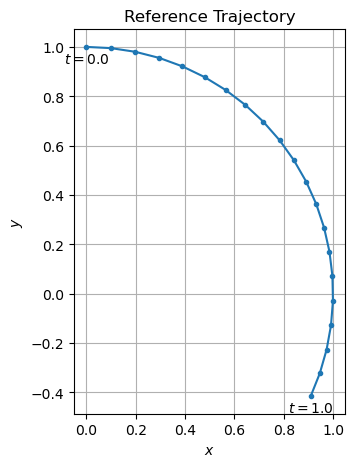

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 5.5))
ax.plot(ref[0, :].T, ref[1, :].T, '.-')
xy0 = np.array(ref[:, 0])
ax.annotate(f'$t={tgrid[0]}$', xy=xy0, xytext=(0, -5), textcoords='offset pixels', va='top', ha='center')
xy_end = np.array(ref[:, -1])
ax.annotate(f'$t={tgrid[-1]}$', xy=xy_end, xytext=(0, -5), textcoords='offset pixels', va='top', ha='center')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Reference Trajectory')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.show()

### 1.1. Run the reference multiple-shooting implementation

Set up optimal control problem

In [8]:
opti = cas.Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[:, k]))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3)) # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3)) # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3)) # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3)) # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10)) # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10)) # force_x limits

# Initial constraints
opti.subject_to(X[:, 0] == cas.vertcat(ref[:, 0], 0, 0))

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #0
  #variables: 2 (nx = 124)
  #parameters: 0 (np = 0)
  #constraints: 27 (ng = 208)
  CasADi solver needs updating.
})

In [9]:
# Use IPOPT solver
opti.solver('ipopt')

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      284
Number of nonzeros in inequality constraint Jacobian.:      124
Number of nonzeros in Lagrangian Hessian.............:       42

Total number of variables............................:      124
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality c

In [10]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(tracking_error) / (N+1))
tracking_rmse

0.08272592095889995

Plot Solution

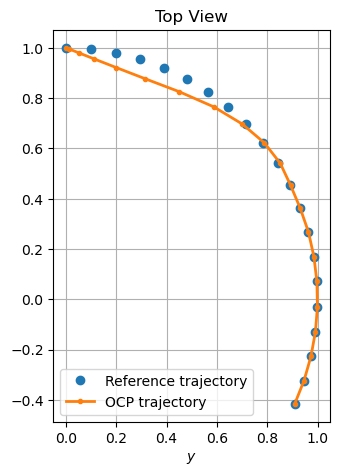

In [11]:
def make_trajectory_plot(xsol, ref, figsize=(3.5, 5.5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(ref[0, :].T, ref[1, :].T, 'o', linewidth=3, label='Reference trajectory')
    ax.plot(xsol[0, :].T, xsol[1, :].T, '.-', linewidth=2, label='OCP trajectory')
    ax.legend()
    ax.set_xlabel('$x$')
    ax.set_xlabel('$y$')
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title('Top View')

xsol = sol.value(X)
make_trajectory_plot(xsol, ref)
plt.tight_layout()
filename = f'toc_sol_1_1a_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

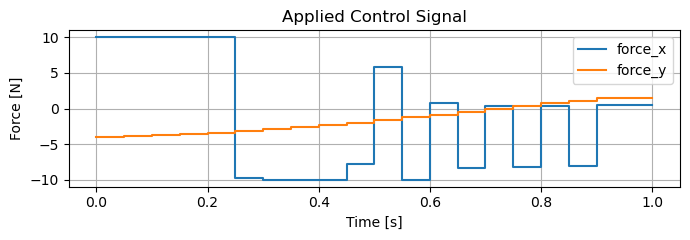

In [12]:
def make_control_signal_plot(usol):
    plt.figure(figsize=(7, 2.5))
    plt.step(tgrid, cas.horzcat(usol, usol[:, -1]).T)
    plt.title('Applied Control Signal')
    plt.legend(('force_x', 'force_y'))
    plt.ylabel('Force [N]')
    plt.xlabel('Time [s]')
    plt.grid()

usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = f'toc_sol_1_1a_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

The reason the optimal solution does not match the reference trajectory is that the reference trajectory is not a feasible solution to the problem as we have defined it above.

The initial state is constrained to `vertcat(ref[:, 0], 0, 0))` which means the particle is stationary. Yet the reference trajectory looks like it is based on a particle that is moving at constant speed in a circle.

#### Modified to allow non-zero initial velocities

In [13]:
opti = cas.Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[:, k]))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3)) # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3)) # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3)) # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3)) # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10)) # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10)) # force_x limits

# Initial constraints - don't set the initial velocities to zero!
opti.subject_to(X[:2, 0] == ref[:, 0])

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #1
  #variables: 2 (nx = 124)
  #parameters: 0 (np = 0)
  #constraints: 27 (ng = 206)
  CasADi solver needs updating.
})

In [14]:
opti.solver('ipopt')

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      282
Number of nonzeros in inequality constraint Jacobian.:      124
Number of nonzeros in Lagrangian Hessian.............:       42

Total number of variables............................:      124
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       82
Total number of inequality constraints...............:      124
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      124
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1000000e+01 1.00e+00 3.44e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

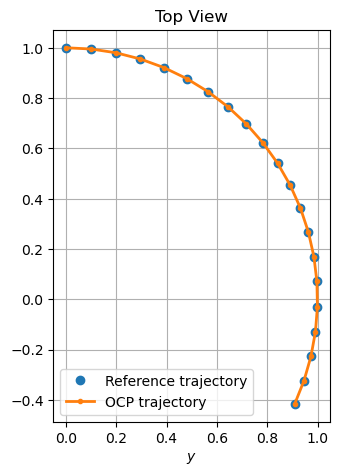

In [15]:
xsol = sol.value(X)
make_trajectory_plot(xsol, ref)
plt.tight_layout()
filename = f'toc_sol_1_1b_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

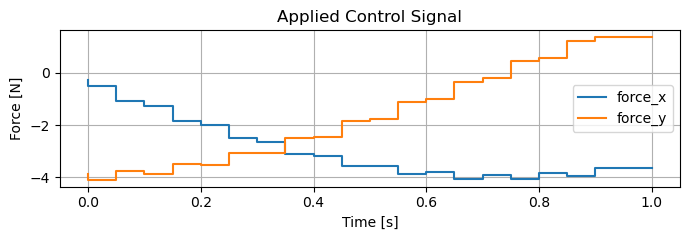

In [16]:
usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = f'toc_sol_1_1b_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

### 1.2 Integration using explicit Euler method and QP solver

In [17]:
# Construct function for the ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]

# Step size
dt = T / N  # length of 1 control interval [s]

# Integration using explicit Euler method
xkp1 = xk + dt * f(xk, uk)

F1 = Function('F1', [xk, uk], [xkp1], ['xk', 'uk'], ['xkp1'])
F1

Function(F1:(xk[4],uk[2])->(xkp1[4]) MXFunction)

In [18]:
opti = cas.Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F1(X[:, k], U[:, k]))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

# Initial constraints
opti.subject_to(X[:, 0] == cas.vertcat(ref[:, 0], 0, 0))
#opti.subject_to(X[:2, 0] == ref[:, 0])

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #2
  #variables: 2 (nx = 124)
  #parameters: 0 (np = 0)
  #constraints: 27 (ng = 208)
  CasADi solver needs updating.
})

In [19]:
# Use SQP solver
options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
options["qpsol_options"] = {"print_iter": False, "print_header": False}
options["print_iteration"] = False
options["print_header"] = False
#options["print_status"] = False
#options["print_time"] = False
opti.solver('sqpmethod', options)

sol = opti.solve()

MESSAGE(sqpmethod): Convergence achieved after 1 iterations
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
          QP  |   1.78ms (  1.78ms)   1.79ms (  1.79ms)         1
  linesearch  |  27.00us ( 27.00us)  27.23us ( 27.23us)         1
      nlp_fg  |  21.00us ( 21.00us)  20.18us ( 20.18us)         1
  nlp_hess_l  |  21.00us ( 21.00us)  21.07us ( 21.07us)         1
  nlp_jac_fg  | 123.00us ( 61.50us) 123.97us ( 61.99us)         2
       total  |   2.92ms (  2.92ms)   4.35ms (  4.35ms)         1


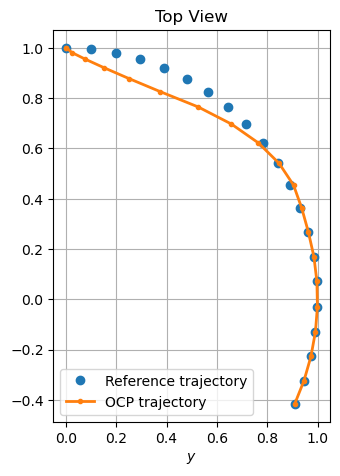

In [20]:
xsol = sol.value(X)
make_trajectory_plot(xsol, ref)
plt.tight_layout()
filename = f'toc_sol_1_2_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [21]:
dir(sol)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__swig_destroy__',
 '__swig_getmethods__',
 '__swig_setmethods__',
 '__weakref__',
 '_opti',
 '_s',
 'debug',
 'disp',
 'opti',
 'repr',
 'stats',
 'str',
 'this',
 'type_name',
 'value',
 'value_parameters',
 'value_variables']

In [22]:
sol.value(tracking_error)

0.2530909487080664

In [23]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(tracking_error) / (N+1))
tracking_rmse

0.10978137336761347

In [24]:
assert np.round(sol.value(tracking_error), 7) == 2.530909e-01

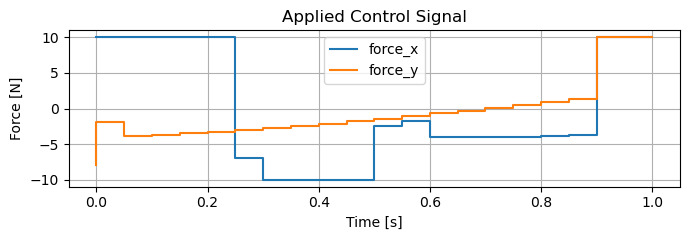

In [25]:
usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = f'toc_sol_1_2_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [26]:
# Number of SQP iterations
sol.stats()['iter_count']

1

Explanation:
 - This takes one iteration because the problem is linear-quadratic — dynamics are linear (pure integrators multiplied by constant step-size -> linear), constraints are linear, and tracking objective is quadratic.

Other comments:
 - Why are the forces zero in the last time step ($0.9 <= t < 1$)?  Maybe because we are using the Euler discretization which means the force at $t=1$ has no influence on the solution.

### 1.3 Control horizon as a bounded decision variable

In [27]:
# Redefine discrete time function to allow for variable time-step

# Construct function for the ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]
dt = MX.sym('dt')  # time step

# Integration using explicit Euler method
xkp1 = xk + dt * f(xk, uk)

F2 = Function('F2', [xk, uk, dt], [xkp1], ['xk', 'uk', 'dt'], ['xkp1'])
F2

Function(F2:(xk[4],uk[2],dt)->(xkp1[4]) MXFunction)

In [28]:
opti = cas.Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Decision variable for control horizon [s]
Tch = opti.variable()

# Gap-closing shooting constraints - with variable control horizon
for k in range(N):
    opti.subject_to(X[:, k+1] == F2(X[:, k], U[:, k], Tch / N))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

# Initial constraints
opti.subject_to(X[:, 0] == cas.vertcat(ref[:, 0], 0, 0))
#opti.subject_to(X[:2, 0] == ref[:, 0])

# Bounds on control horizon
opti.subject_to(opti.bounded(0.5, Tch, 2))

# Initial guess for control horizon
opti.set_initial(Tch, 1)

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #3
  #variables: 3 (nx = 125)
  #parameters: 0 (np = 0)
  #constraints: 28 (ng = 209)
  CasADi solver needs updating.
})

In [29]:
opti.solver('ipopt')

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      324
Number of nonzeros in inequality constraint Jacobian.:      125
Number of nonzeros in Lagrangian Hessian.............:      122

Total number of variables............................:      125
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:      125
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      125
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1000000e+01 1.00e+00 3.20e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

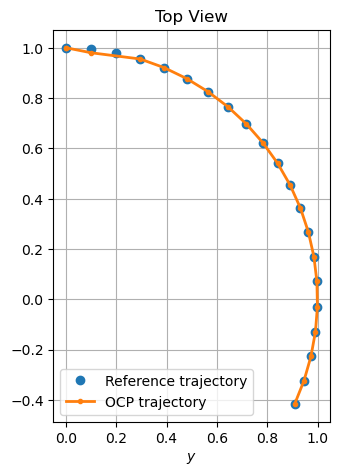

In [30]:
xsol = sol.value(X)
make_trajectory_plot(xsol, ref)
plt.tight_layout()
filename = f'toc_sol_1_3a_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

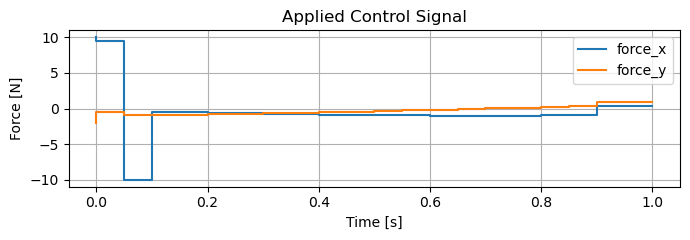

In [31]:
usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = f'toc_sol_1_3a_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [32]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(tracking_error) / (N+1))
tracking_rmse

0.030649970850811285

In [33]:
assert np.round(sol.value(tracking_error), 8) == 1.972783e-02

In [34]:
Tch_sol = sol.value(Tch)
Tch_sol

1.9999999742240357

Explanation:
 - The solver has increased the control horizon time to 2 seconds giving it more time to accelerate to catch up with the reference trajectory

#### Repeat with SQP solver

In [35]:
opti = cas.Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Decision variable for control horizon [s]
Tch = opti.variable()

# Gap-closing shooting constraints - with variable control horizon
for k in range(N):
    opti.subject_to(X[:, k+1] == F2(X[:, k], U[:, k], Tch / N))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

# Initial constraints
opti.subject_to(X[:, 0] == cas.vertcat(ref[:, 0], 0, 0))
#opti.subject_to(X[:2, 0] == ref[:, 0])

# Bounds on control horizon
opti.subject_to(opti.bounded(0.5, Tch, 2))

# Initial guess for control horizon
opti.set_initial(Tch, 1)

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #4
  #variables: 3 (nx = 125)
  #parameters: 0 (np = 0)
  #constraints: 28 (ng = 209)
  CasADi solver needs updating.
})

In [36]:
# Use SQP solver
options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
options["qpsol_options"] = {"print_iter": False, "print_header": False}
options["print_iteration"] = False
options["print_header"] = False
#options["print_status"] = False
#options["print_time"] = False
options["convexify_strategy"] = "eigen-clip"
opti.solver('sqpmethod', options)

sol = opti.solve()

MESSAGE(sqpmethod): Convergence achieved after 11 iterations
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
          QP  | 269.20ms ( 24.47ms) 268.65ms ( 24.42ms)        11
   convexify  |   6.67ms (606.45us)   6.69ms (608.54us)        11
  linesearch  | 409.00us ( 37.18us) 396.85us ( 36.08us)        11
      nlp_fg  | 341.00us ( 17.05us) 336.76us ( 16.84us)        20
  nlp_hess_l  | 802.00us ( 72.91us) 801.06us ( 72.82us)        11
  nlp_jac_fg  |   1.04ms ( 87.08us)   1.05ms ( 87.36us)        12
       total  | 279.51ms (279.51ms) 278.42ms (278.42ms)         1


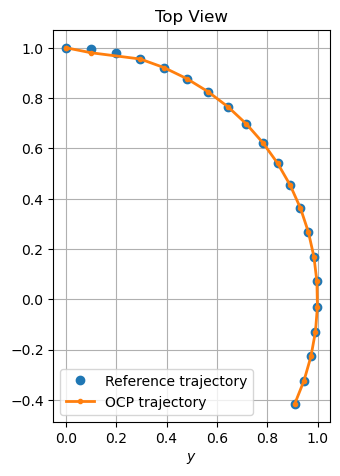

In [37]:
xsol = sol.value(X)
make_trajectory_plot(xsol, ref)
plt.tight_layout()
filename = f'toc_sol_1_3b_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

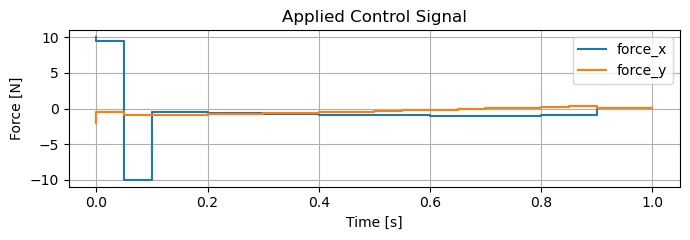

In [38]:
usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = f'toc_sol_1_3b_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [39]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(tracking_error) / (N+1))
tracking_rmse

0.030649968935725733

In [40]:
Tch_sol = sol.value(Tch)
Tch_sol

2.0

In [41]:
# Number of SQP iterations
sol.stats()['iter_count']

11

Explanation:
 - SQP method takes more than one iteration because the problem is no longer a QP because $\Delta T$ is a decision variable and the RHS now contains products of decision variables:

$$
\begin{aligned}
\underset{x_1,x_2,...,x_{N+1},u_1,u_2,...,u_N,\Delta T}{\text{minimize}} \quad & ... \\
\text{subject to} \quad & x_{k+1} = x_k + \Delta T(Ax_k + Bu_k), \quad k=1, ..., N
\end{aligned}
$$

Therefore, local approximations (linearizations) are no longer perfect and more steps are required.

In summary, allowing a time-varying horizon (end-time) makes the problem harder to solve.  One option is to solve with a fixed time horizon to generate an initial solution and then solve with a variable time horizon.

#### Dense column in the constraint Jacobian

Plot sparsity of the constraint Jacobian $\frac{\partial g(x)}{\partial x}$

<img src="images/constraint_jacobian.png" width="400">

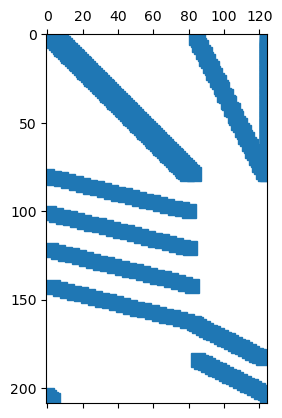

In [42]:
plt.figure()
plt.spy(sol.value(cas.jacobian(opti.g, opti.x)))
plt.show()

### 1.4 Re-implement avoiding the dense column in the constraint Jacobian

Explanation of the dense column in the constraint Jacobian:
 - All the states depend on $\Delta T$

Solution:
 - Modify the problem by creating a local timestep for each iteration, $\Delta T_k$, and then add constraints to ensure $\Delta T_{k+1} = \Delta T_k$.

In [43]:
opti = cas.Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Decision variables for control action horizon [s]
Tch = opti.variable(N+1)

# Gap-closing shooting constraints - with variable control horizon
for k in range(N):
    opti.subject_to(X[:, k+1] == F2(X[:, k], U[:, k], Tch[k] / N))
    opti.subject_to(Tch[k+1] == Tch[k])

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

# Initial constraints
opti.subject_to(X[:, 0] == cas.vertcat(ref[:, 0], 0, 0))
#opti.subject_to(X[:2, 0] == ref[:, 0])

# Bounds on control horizon
opti.subject_to(opti.bounded(0.5, Tch, 2))

# Initial guess for control horizon
opti.set_initial(Tch, 1)

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #5
  #variables: 3 (nx = 145)
  #parameters: 0 (np = 0)
  #constraints: 48 (ng = 249)
  CasADi solver needs updating.
})

In [44]:
# Use SQP solver
options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
options["qpsol_options"] = {"print_iter": False, "print_header": False}
options["print_iteration"] = False
options["print_header"] = False
#options["print_status"] = False
#options["print_time"] = False
options["convexify_strategy"] = "eigen-clip"
opti.solver('sqpmethod', options)

sol = opti.solve()

MESSAGE(sqpmethod): Convergence achieved after 10 iterations
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
          QP  |  14.72ms (  1.47ms)  15.87ms (  1.59ms)        10
   convexify  | 210.00us ( 21.00us) 208.70us ( 20.87us)        10
  linesearch  | 352.00us ( 35.20us) 353.31us ( 35.33us)        10
      nlp_fg  | 297.00us ( 16.50us) 301.00us ( 16.72us)        18
  nlp_hess_l  | 649.00us ( 64.90us) 668.58us ( 66.86us)        10
  nlp_jac_fg  |   1.12ms (101.45us)   1.13ms (102.48us)        11
       total  |  18.33ms ( 18.33ms)  19.05ms ( 19.05ms)         1


Note: time taken to convexify the problem has reduced from ~6 ms to 187 us.

This is because this new structure can be transformed to block diagonal Hessian, so convexification can be performed block-wise.


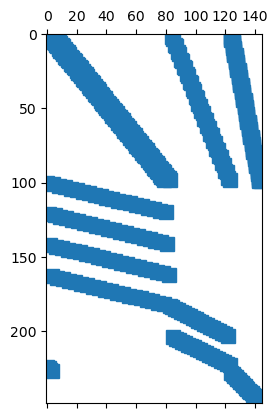

In [45]:
plt.figure()
plt.spy(sol.value(cas.jacobian(opti.g, opti.x)))
plt.show()

In [46]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(tracking_error) / (N+1))
tracking_rmse

0.030649968936675577

In [47]:
Tch_sol = sol.value(Tch)
Tch_sol

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2.])

## 2. Racing Around Obstacles

### Start again from template with a circle in the scene

In [48]:
# Constants
N = 20  # Number of control intervals

tgrid = np.linspace(0, T, N+1)

### Define continuous-time system

$\dot{x} = f(x,u)$

In [49]:
nx = 4

# Construct function for the ODE right-hand side
x = MX.sym('x', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
u = MX.sym('u', 2)  # control force [N]
rhs = cas.vertcat(x[2:4], u)

# Continuous system dynamics as a CasADi Function
f = Function('f', [x, u], [rhs])
f

Function(f:(i0[4],i1[2])->(o0[4]) MXFunction)

### Define discrete-time system

$x_{k+1} = F(x_k, u_k)$

In [50]:
# Construct function for the ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]

# Step size (variable)
dt = MX.sym('dt') # length of 1 control interval [s]

# RK4 approximation
f1 = f(xk, uk)
f2 = f(xk + dt/2 * f1, uk)
f3 = f(xk + dt/2 * f2, uk)
f4 = f(xk + dt * f3, uk)
xkp1 = xk + dt / 6 * (f1 + 2 * f2 + 2 * f3 + f4)

F = Function('F', [xk, uk, dt], [xkp1], ['xk', 'uk', 'dt'], ['xkp1'])
F

Function(F:(xk[4],uk[2],dt)->(xkp1[4]) MXFunction)

### Obstacle

Circle centered around (1; 0:75) with a radius of 0:6.


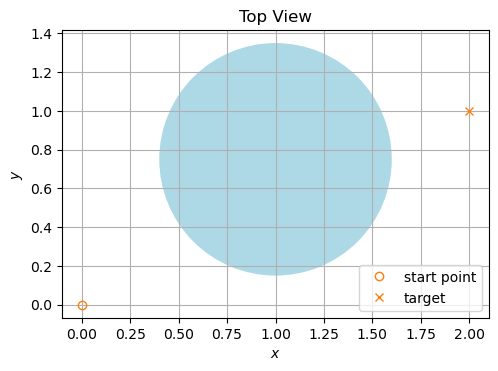

In [51]:
obstacle_centre = (1.0, 0.75)
obstacle_radius = 0.6
start_pt = (0.0, 0.0)
target_pt = (2.0, 1.0)

fig, ax = plt.subplots(figsize=(5.5, 5.5))
circle = plt.Circle(
    obstacle_centre, 
    obstacle_radius, 
    facecolor='lightblue',
)
ax.add_patch(circle)
plt.plot(start_pt[0], start_pt[1], 'o', fillstyle='none', markeredgecolor='tab:orange', label='start point')
plt.plot(target_pt[0], target_pt[1], 'x', fillstyle='none', markeredgecolor='tab:orange', label='target')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Top View')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend()
plt.show()

### 2.1 Find the time optimal trajectory that starts from standstill at (0; 0) and ends at (2; 1) without a prescribed final velocity.

#### Run the reference multiple-shooting implementation

Set up optimal control problem

In [52]:
opti = cas.Opti()

# Decision variables for simulation time
T = opti.variable()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[:, k], T/N))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3)) # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3)) # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3)) # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3)) # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10)) # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10)) # force_x limits

# Obstacle avoidance
for k in range(N+1):
    # Note: cas.norm_2 is not vectorizable
    distance_from_obstacle_centre = cas.norm_2(X[:2, k] - cas.DM(obstacle_centre))
    opti.subject_to(distance_from_obstacle_centre > cas.DM(obstacle_radius))

# Time is bounded
opti.subject_to(opti.bounded(0.5, T, 2))
opti.set_initial(T, 1)

# Start and end constraints
opti.subject_to(X[:, 0] == cas.vertcat(cas.DM(start_pt), 0, 0))
opti.subject_to(X[:2, -1] == cas.DM(target_pt))

# Initial guess
opti.set_initial(X[0,:], np.linspace(start_pt[0], target_pt[0], N+1))
opti.set_initial(X[1,:], np.linspace(start_pt[1], target_pt[1], N+1))

# Use this initial condition and it will find the sub-optimal solution
#opti.set_initial(X[1,:], np.linspace(start_pt[1], target_pt[1]*2, N+1))

# Try to follow the waypoints
opti.minimize(T)
opti

Opti(Opti {
  instance #6
  #variables: 3 (nx = 125)
  #parameters: 0 (np = 0)
  #constraints: 50 (ng = 232)
  CasADi solver needs updating.
})

In [53]:
# Use IPOPT solver
opti.solver('ipopt')

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      366
Number of nonzeros in inequality constraint Jacobian.:      167
Number of nonzeros in Lagrangian Hessian.............:      144

Total number of variables............................:      125
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       86
Total number of inequality constraints...............:      146
        inequality constraints with only lower bounds:       21
   inequality constraints with lower and upper bounds:      125
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 3.76e-01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Plot Solution

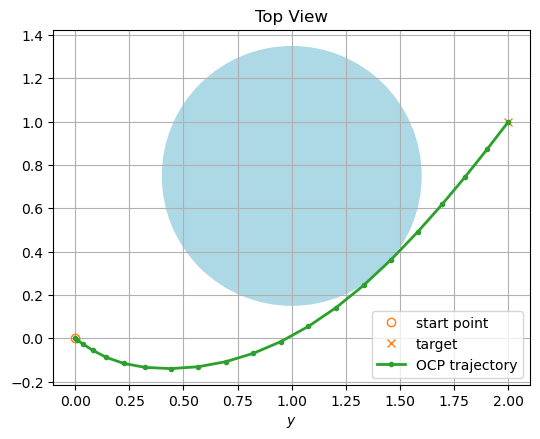

In [54]:
def make_trajectory_plot_with_obstacle(xsol, start_pt, target_pt, obstacle_centre, obstacle_radius, figsize=(5.5, 5.5)):
    fig, ax = plt.subplots(figsize=figsize)
    circle = plt.Circle(
        obstacle_centre, 
        obstacle_radius, 
        facecolor='lightblue',
    )
    ax.add_patch(circle)
    plt.plot(start_pt[0], start_pt[1], 'o', fillstyle='none', markeredgecolor='tab:orange', label='start point')
    plt.plot(target_pt[0], target_pt[1], 'x', fillstyle='none', markeredgecolor='tab:orange', label='target')
    ax.plot(xsol[0, :].T, xsol[1, :].T, '.-', linewidth=2, label='OCP trajectory')
    ax.legend()
    ax.set_xlabel('$x$')
    ax.set_xlabel('$y$')
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title('Top View')

xsol = sol.value(X)
make_trajectory_plot_with_obstacle(xsol, start_pt, target_pt, obstacle_centre, obstacle_radius)
plt.tight_layout()
filename = f'toc_sol_1_1a_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

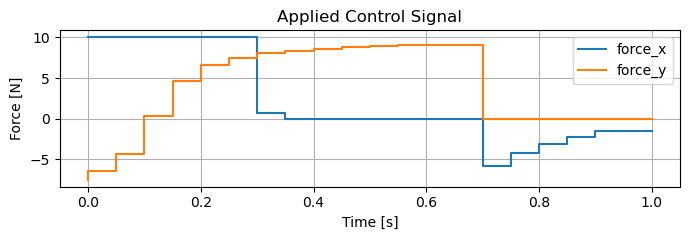

In [55]:
def make_control_signal_plot(usol):
    plt.figure(figsize=(7, 2.5))
    plt.step(tgrid, cas.horzcat(usol, usol[:, -1]).T)
    plt.title('Applied Control Signal')
    plt.legend(('force_x', 'force_y'))
    plt.ylabel('Force [N]')
    plt.xlabel('Time [s]')
    plt.grid()

usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = f'toc_sol_1_1a_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [56]:
T_sol = sol.value(T)
print(T_sol)
assert np.round(T_sol, 8) in [1.0437847e+00, 8.4867232e-01] 

0.8486723195929504
